In [1]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.metrics import multilabel_confusion_matrix, classification_report
from keras.models import load_model 
from sklearn.metrics import confusion_matrix

# Loading the data

In [ ]:
network_data1 = pd.read_csv('deeplearning/02-15-2018.csv', low_memory=False)
network_data2 = pd.read_csv('deeplearning/02-16-2018.csv', low_memory=False)
network_data3 = pd.read_csv('deeplearning/02-20-2018.csv', low_memory=False)
network_data4 = pd.read_csv('deeplearning/02-21-2018.csv', low_memory=False)


# not needed
network_data3.drop(columns=['Flow ID', 'Src IP', 'Src Port', 'Dst IP'], axis=1,inplace=True)



network_data = pd.concat([network_data1, network_data2], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data1, network_data2
print('packets 1 and 2 finished')

network_data = pd.concat([network_data, network_data3], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data3
print('packet 3 finished')

network_data = pd.concat([network_data, network_data4], axis=0)
network_data.reset_index(drop=True, inplace=True)
del network_data4
print('packet 4 finished')

## Data visualizations

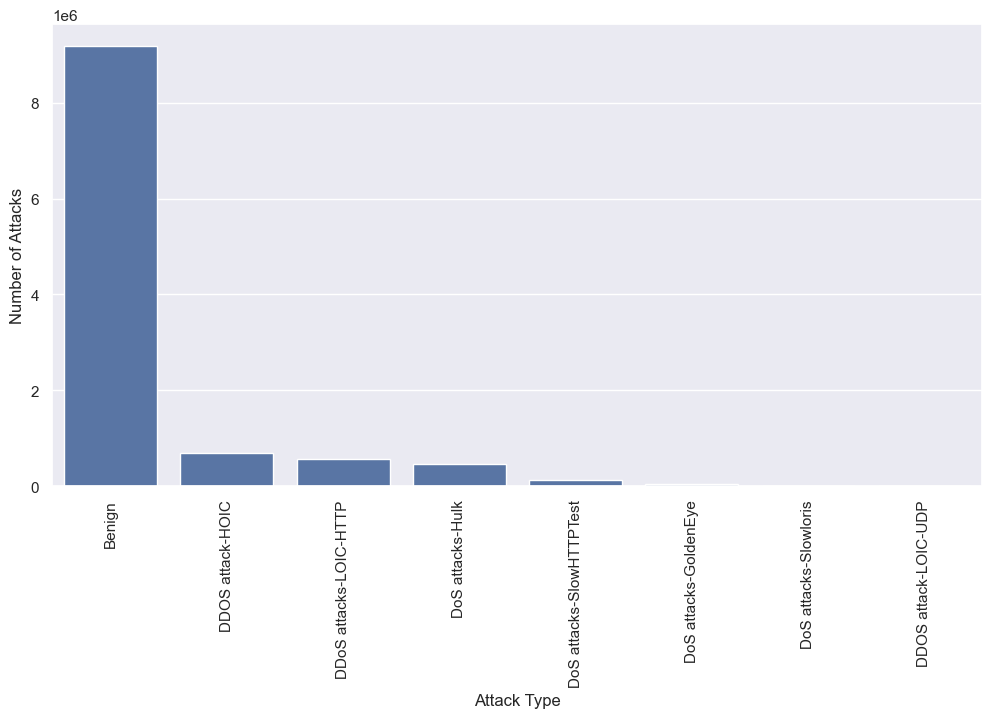

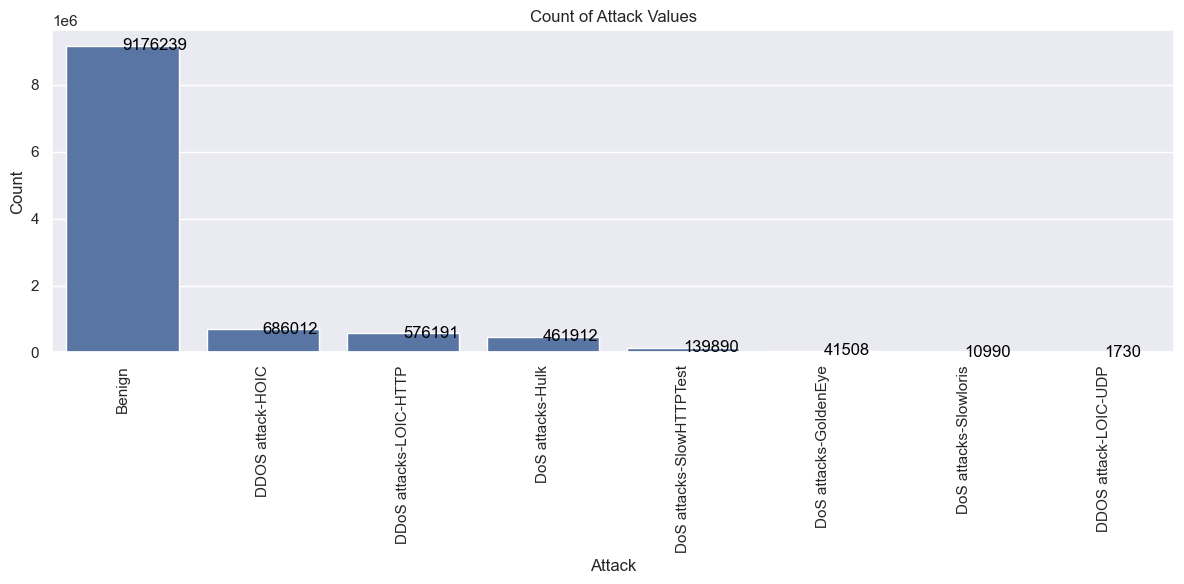

In [4]:
# make a plot number of labels
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=network_data, order=network_data['Label'].value_counts().index)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.xticks(rotation=90)
plt.show()


fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(x=network_data['Label'], ax=ax,  order=network_data['Label'].value_counts().index)

for i, v in enumerate(network_data['Label'].value_counts()):
    ax.text(i, v, str(v), color='black', va='center')

plt.xlabel('Attack')
plt.ylabel('Count')
plt.title('Count of Attack Values')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Data Preprocessing

In [5]:
# check for some null or missing values in our dataset
print(network_data.shape)
network_data.isna().sum().to_numpy()

(11094472, 80)


array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0, 41688,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int64)

In [6]:
# drop null or missing columns
cleaned_data = network_data.dropna()
cleaned_data.isna().sum().to_numpy()

print(network_data.shape)

(11094472, 80)


### Label Encoding

In [7]:
# encode the column labels
le = LabelEncoder()
cleaned_data['Label']= le.fit_transform(cleaned_data['Label'])

C:\Users\doo\AppData\Local\Temp\ipykernel_21796\2295283738.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
# check for encoded labels
cleaned_data['Label'].value_counts()

Label
0    9134551
1     686012
3     576191
5     461912
6     139890
4      41508
7      10990
2       1730
Name: count, dtype: int64

In [9]:
#0       Benign                      9176239
#1       DDOS attack-HOIC             686012
#3       DDoS attacks-LOIC-HTTP       576191
#5       DoS attacks-Hulk             461912
#6       DoS attacks-SlowHTTPTest     139890
#4       DoS attacks-GoldenEye         41508
#7       DoS attacks-Slowloris         10990
#2       DDOS attack-LOIC-UDP           1730

#0       Benign                      9176239
#1       DDOS attack-HOIC             686012
#2       DDOS attack-LOIC-UDP           1730
#3       DDoS attacks-LOIC-HTTP       576191
#4       DoS attacks-GoldenEye         41508
#5       DoS attacks-Hulk             461912
#6       DoS attacks-SlowHTTPTest     139890
#7       DoS attacks-Slowloris         10990


data_1 = cleaned_data[cleaned_data['Label'] == 0] # Benign                     data
data_2 = cleaned_data[cleaned_data['Label'] == 1] # DDOS attack-HOIC           data
data_3 = cleaned_data[cleaned_data['Label'] == 3] # DDoS attacks-LOIC-HTTP     data
data_4 = cleaned_data[cleaned_data['Label'] == 5] # DoS attacks-Hulk           data
data_5 = cleaned_data[cleaned_data['Label'] == 6] # DoS attacks-SlowHTTPTest   data
data_6 = cleaned_data[cleaned_data['Label'] == 4] # DoS attacks-GoldenEye      data
data_7 = cleaned_data[cleaned_data['Label'] == 7] # DoS attacks-Slowloris      data
data_8 = cleaned_data[cleaned_data['Label'] == 2] # DDOS attack-LOIC-UDP       data




y_Benign                   = pd.DataFrame(np.zeros(data_1.shape[0]))
y_DDOS_attack_HOIC         = pd.DataFrame(np.ones(data_2.shape[0]))
y_DDoS_attacks_LOIC_HTTP   = pd.DataFrame(np.full(data_3.shape[0], 3))
y_DoS_attacks_Hulk         = pd.DataFrame(np.full(data_4.shape[0], 5))
y_DoS_attacks_SlowHTTPTest = pd.DataFrame(np.full(data_5.shape[0], 6))
y_DoS_attacks_GoldenEye    = pd.DataFrame(np.full(data_6.shape[0], 4))
y_DoS_attacks_Slowloris    = pd.DataFrame(np.full(data_7.shape[0], 7))
y_DDOS_attack_LOIC_UDP     = pd.DataFrame(np.full(data_8.shape[0], 2))




# merging the categorial data
X = pd.concat([data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8], sort=True)
y = pd.concat([y_Benign, y_DDOS_attack_HOIC, y_DDoS_attacks_LOIC_HTTP, y_DoS_attacks_Hulk, y_DoS_attacks_SlowHTTPTest, y_DoS_attacks_GoldenEye, y_DoS_attacks_Slowloris, y_DDOS_attack_LOIC_UDP], sort=True)

## Data Argumentation
our data is unbalanced nad needs balancing to avoid bias in our model

In [10]:
from sklearn.utils import resample

data_1_resample = resample(data_1, n_samples=20000, random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000, random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=20000, random_state=123, replace=True)
data_4_resample = resample(data_4, n_samples=20000, random_state=123, replace=True)
data_5_resample = resample(data_5, n_samples=20000, random_state=123, replace=True)
data_6_resample = resample(data_6, n_samples=20000, random_state=123, replace=True)
data_7_resample = resample(data_7, n_samples=20000, random_state=123, replace=True)
data_8_resample = resample(data_8, n_samples=20000, random_state=123, replace=True)

In [11]:
train_dataset = pd.concat([data_1_resample, data_2_resample, data_3_resample, data_4_resample, data_5_resample, data_6_resample, data_7_resample, data_8_resample])

Label
0    9134551
1     686012
3     576191
5     461912
6     139890
4      41508
7      10990
2       1730
Name: count, dtype: int64


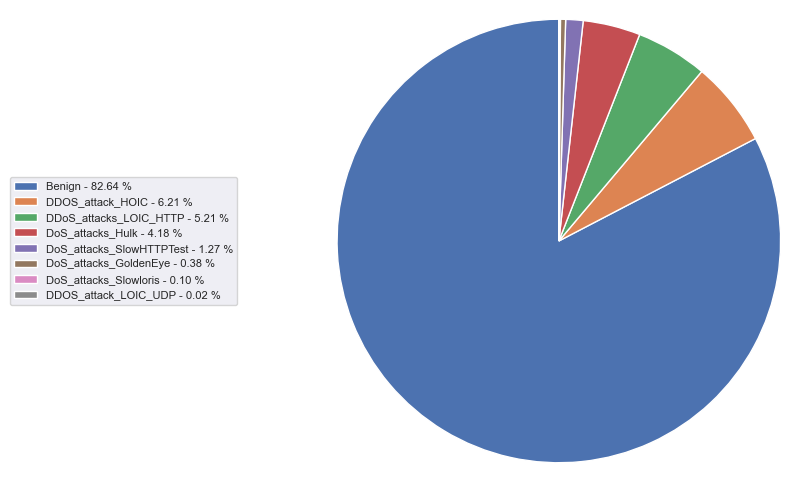

In [12]:
y = X['Label'].value_counts()
print(y)
x = ["Benign","DDOS_attack_HOIC","DDoS_attacks_LOIC_HTTP","DoS_attacks_Hulk","DoS_attacks_SlowHTTPTest","DoS_attacks_GoldenEye","DoS_attacks_Slowloris","DDOS_attack_LOIC_UDP"]

porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.7, 0.5),
           fontsize=8)

plt.savefig('piechart.png', bbox_inches='tight')


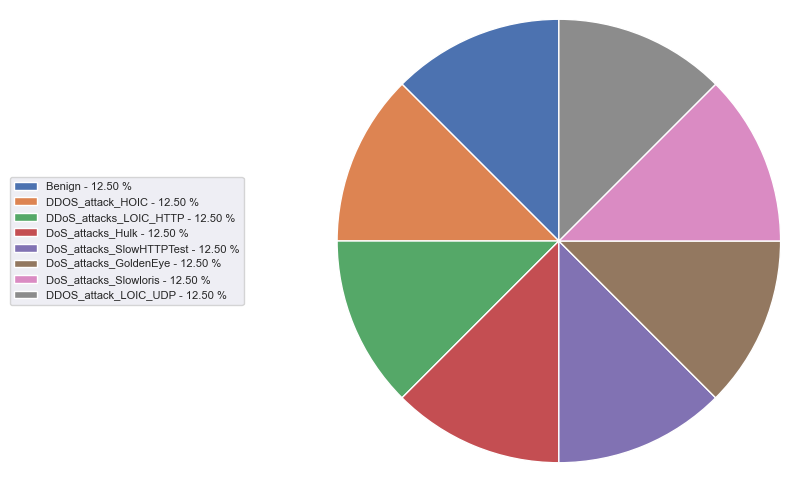

In [13]:
y = train_dataset['Label'].value_counts()
x = ["Benign","DDOS_attack_HOIC","DDoS_attacks_LOIC_HTTP","DoS_attacks_Hulk","DoS_attacks_SlowHTTPTest","DoS_attacks_GoldenEye","DoS_attacks_Slowloris","DDOS_attack_LOIC_UDP"]

porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, startangle=90, radius=1.2)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.7, 0.5),
           fontsize=8)

plt.savefig('piechart.png', bbox_inches='tight')


## splitting data to training and testing sets

In [14]:
test_dataset = train_dataset.sample(frac=0.1)
target_train = train_dataset['Label']
target_test = test_dataset['Label']

In [15]:
y_train = to_categorical(target_train, num_classes=8)
y_test = to_categorical(target_test, num_classes=8)

print(y_train.shape)
print(y_test.shape)

(160000, 8)
(16000, 8)


In [16]:
train_dataset = train_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)
test_dataset = test_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)

print(train_dataset.shape)
print(test_dataset.shape)

(160000, 73)
(16000, 73)


In [17]:
X_train = train_dataset.iloc[:, :-1].values
X_test = test_dataset.iloc[:, :-1].values

In [18]:
print(X_train.shape)
print(X_test.shape)

(160000, 72)
(16000, 72)


In [19]:
# reshape the data for th CNN model
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((160000, 72, 1), (16000, 72, 1))

In [20]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    
    # adding a pooling layer
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(8, activation='softmax'))
    from keras import metrics
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
model = model()
model.summary()

C:\Users\doo\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 72, 64)         │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 72, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 36, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 36, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 36, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 18, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 18, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,104 (359.78 KB)

 Trainable params: 91,720 (358.28 KB)

 Non-trainable params: 384 (1.50 KB)

In [22]:
his = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - accuracy: 0.8104 - loss: 0.4164 - val_accuracy: 0.6932 - val_loss: 0.9142
Epoch 2/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8728 - loss: 0.2434 - val_accuracy: 0.8758 - val_loss: 0.2223
Epoch 3/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8815 - loss: 0.2238 - val_accuracy: 0.8468 - val_loss: 0.3351
Epoch 4/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.8872 - loss: 0.2151 - val_accuracy: 0.9010 - val_loss: 0.1985
Epoch 5/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8914 - loss: 0.2057 - val_accuracy: 0.7718 - val_loss: 0.4753
Epoch 6/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8913 - loss: 0.2037 - val_accuracy: 0.9039 - val_loss: 0.1900
Epoch 7/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8934 - loss: 0.2023 - val_accuracy: 0.8715 - val_loss: 0.2481
Epoch 8/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8947 - loss: 0

## Results

In [34]:
model.save('CNN_model.keras')

loss, acc = model.evaluate(X_test, y_test)



print("accuracy: ", acc)
print("loss: ", loss)

print("////////////////")
print("////////////////")
print("////////////////")
print("////////////////")


# ordered labels according to the encoding
labels = [
    "Benign",
    "DDOS attack-HOIC",
    "DDOS attack-LOIC-UDP",
    "DDoS attacks-LOIC-HTTP",
    "DoS attacks-GoldenEye",
    "DoS attacks-Hulk",
    "DoS attacks-SlowHTTPTest",
    "DoS attacks-Slowloris"
]



y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)


print("Multilabel Classification Report")
print(classification_report(y_test_class, y_pred_class, target_names=labels))


500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9835 - loss: 0.0679
accuracy:  0.9816874861717224
loss:  0.07051262259483337
////////////////
////////////////
////////////////
////////////////
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Multilabel Classification Report
                          precision    recall  f1-score   support

                  Benign       0.89      0.98      0.94      1947
        DDOS attack-HOIC       0.99      0.89      0.94      1942
    DDOS attack-LOIC-UDP       1.00      1.00      1.00      1999
  DDoS attacks-LOIC-HTTP       0.98      0.99      0.99      2122
   DoS attacks-GoldenEye       1.00      1.00      1.00      2066
        DoS attacks-Hulk       1.00      1.00      1.00      1933
DoS attacks-SlowHTTPTest       1.00      1.00      1.00      2004
   DoS attacks-Slowloris       1.00      0.99      0.99      1987

                accuracy                           0.98     16000
               macro avg       0.98      0.98      0.98     1600

500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


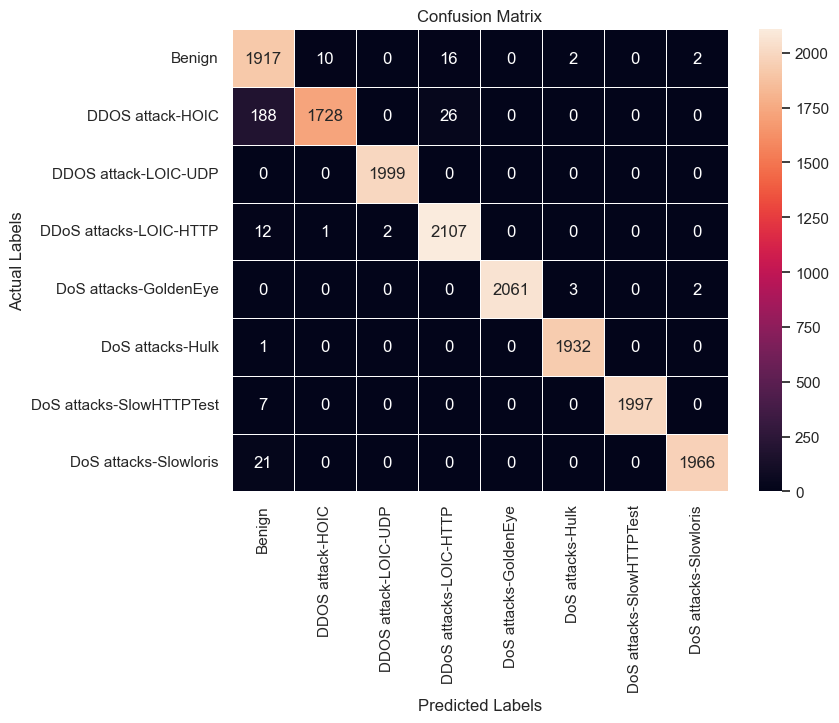

In [31]:
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)



conf_mat = confusion_matrix(y_test_class, y_pred_class)

fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(conf_mat, annot=True,  fmt='d', ax=ax, linewidth=0.5)





ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')






ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels, rotation=0)


plt.show()

In [32]:
history = his.history
history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

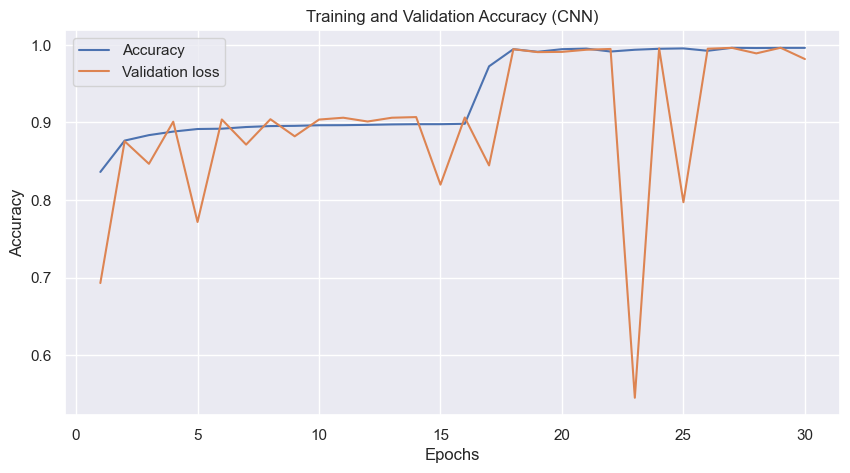

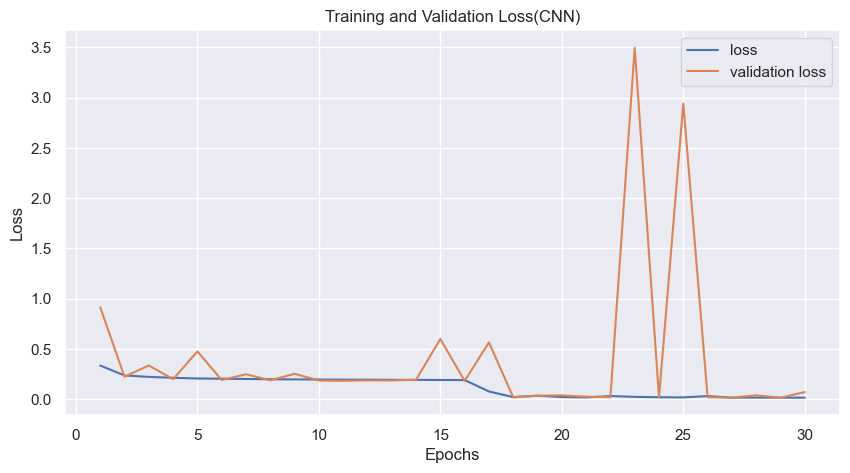

In [33]:
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

# visualize training and val accuracy
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, label='Validation loss')
plt.legend()

# visualize train and val loss
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss(CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()